In [1]:
import math
from statistics import mean, stdev
import numpy as np
import pandas as pd
import pandas.io.sql as pd_sql
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from functions.formatting.text_tools import snake_to_pascal_case, add_space_to_prefix
from functions.plotting.mpl import plot_single_scatter, plot_qq
from functions.auth.connections import postgres_connection

connection_uri = postgres_connection(database='mountain_project')

In [2]:
save=False

# Get Data

In [3]:
query = """
SELECT b.avg_stars, b.length_, b.grade,
       r.star_ratings, r.on_to_do_lists, r.ticks,
       t.log_star_ratings, t.log_ticks, t.log_length, t.log_on_to_do_lists,
       t.sqrt_star_ratings, t.sqrt_ticks, t.sqrt_avg_stars, t.sqrt_length, t.sqrt_grade
FROM routes b
LEFT JOIN ratings r ON b.url_id = r.url_id
LEFT JOIN feature_transforms t ON b.url_id = t.url_id
WHERE b.area_name IN ('buttermilks', 'druid_stones', 'happy_boulders', 'sad_boulders')
  AND length_ IS NOT NULL
;
"""
df = pd_sql.read_sql(query, connection_uri) # grab data as a dataframe
df = df.reset_index(drop=True)
df.columns = [snake_to_pascal_case(col) for col in df.columns] # rename columns
df.columns = [add_space_to_prefix(col, ['Log', 'Sqrt']) for col in df.columns] # Add space before Log or Sqrt
df.head()

,AvgStars,Length,Grade,StarRatings,OnToDoLists,Ticks,Log StarRatings,Log Ticks,Log Length,Log OnToDoLists,Sqrt StarRatings,Sqrt Ticks,Sqrt AvgStars,Sqrt Length,Sqrt Grade
0,1.3,10.0,-1.00,30,8,52,1.491362,1.724276,1.041393,0.954243,5.477226,7.211103,1.140175,3.162278,0.000000
1,2.0,15.0,-1.00,1,0,1,0.301030,0.301030,1.204120,0.000000,1.000000,1.000000,1.414214,3.872983,0.000000
2,2.2,18.0,-0.25,41,11,87,1.623249,1.944483,1.278754,1.079181,6.403124,9.327379,1.483240,4.242641,0.866025
3,2.8,18.0,-0.25,84,49,168,1.929419,2.227887,1.278754,1.698970,9.165151,12.961481,1.673320,4.242641,0.866025
4,1.8,12.0,-0.25,46,12,102,1.672098,2.012837,1.113943,1.113943,6.782330,10.099505,1.341641,3.464102,0.866025


# Ensemble

In [4]:
# Used for K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 72)
scaler = StandardScaler()

In [5]:
# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(df.drop(columns = ['Log OnToDoLists']), df['Log OnToDoLists'], test_size=.2, random_state=42)

# Choose features, KFold requires ndarray inputs
features_list = ['Log StarRatings', 'Log Ticks', 'AvgStars', 'Log Length', 'Grade',                
                 'Sqrt StarRatings', 'Sqrt Ticks', 'Sqrt AvgStars', 'Sqrt Length', 'Sqrt Grade']

features_train_chosen_df = features_train_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
features_test_chosen_df = features_test_all_df[features_list]
features_test_chosen_array = np.array(features_test_chosen_df)
target_train_array = np.array(target_train_ser)
target_test_array = np.array(target_test_ser)

In [6]:
# Grid search

r2_cv_full_mean_list, r2_test_list = [], []

for i in tqdm(range(101)):

    # KFold Cross-Validation
    r2_cv_list = [] # Collect the cross-validation results

    for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):

        # Make the split
        features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
        features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 

        # Standard Scaler
        features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)
        features_val_cv_scaled_array = scaler.transform(features_val_cv_array)

        # Fit OLS
        ols_model = sm.OLS(target_train_cv_array, sm.add_constant(features_train_cv_scaled_array[:,0:5]))
        ols_results = ols_model.fit() # Fit model

        features_train_cv_scaled_df = pd.DataFrame(features_train_cv_scaled_array[:,5:10]).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
        features_train_cv_scaled_df['OnToDoLists'] = 10**target_train_cv_array-1
        features_val_cv_scaled_df = pd.DataFrame(features_val_cv_scaled_array[:,5:10]).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
        features_val_cv_scaled_df['OnToDoLists'] = 10**target_val_cv_array-1

        # Fit Poisson
        poisson_glm_model = smf.glm("OnToDoLists ~ Sqrt_StarRatings + Sqrt_Ticks + Sqrt_Avg_Stars + Sqrt_Length + Sqrt_Grade", data=features_train_cv_scaled_df, family=sm.families.Poisson())
        poisson_glm_results = poisson_glm_model.fit()

        # Ensemble Model
        ensemble_array = 0.01*i*(10**ols_results.predict(sm.add_constant(features_val_cv_scaled_array[:,0:5]))-1) + (1-0.01*i)*poisson_glm_results.predict(features_val_cv_scaled_df)

        # Collect results on the validation set
        SSE = sum((10**target_val_cv_array-1 - ensemble_array)**2)
        SST = sum((10**target_val_cv_array-1 - np.mean(10**target_val_cv_array-1))**2)
        r2_cv_list.append(1-SSE/SST)

    #print(r2_cv_list)
    #print('val_r2_score: ', mean(r2_cv_list),' +/- ', stdev(r2_cv_list))
    r2_cv_full_mean_list.append(mean(r2_cv_list))

    # Test
    features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
    features_test_scaled_array = scaler.transform(features_test_chosen_df)

    # Fit OLS
    ols_model = sm.OLS(target_train_ser, sm.add_constant(features_train_scaled_array[:,0:5]))
    ols_results = ols_model.fit()

    # Fit Poisson
    features_train_scaled_df = pd.DataFrame(features_train_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
    features_train_scaled_df['OnToDoLists'] = 10**target_train_array-1
    features_test_scaled_df = pd.DataFrame(features_test_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
    features_test_scaled_df['OnToDoLists'] = 10**target_test_array-1

    poisson_glm_model = smf.glm("OnToDoLists ~ Sqrt_StarRatings + Sqrt_Ticks + Sqrt_Avg_Stars + Sqrt_Length + Sqrt_Grade", data=features_train_scaled_df, family=sm.families.Poisson())
    poisson_glm_results = poisson_glm_model.fit()

    # Ensemble Model
    ensemble_array = 0.01*i*(10**ols_results.predict(sm.add_constant(features_test_scaled_array[:,0:5]))-1) + (1-0.01*i)*poisson_glm_results.predict(features_test_scaled_df)

    # Collect results on the test set
    SSE = sum((10**target_test_array-1 - ensemble_array)**2)
    SST = sum((10**target_test_array-1 - np.mean(10**target_test_array-1))**2)

    #print('test_r2_score: ', 1-SSE/SST) #Get score
    r2_test_list.append(1-SSE/SST)

In [7]:
r2_cv_full_mean_list.index(max(r2_cv_full_mean_list))

76

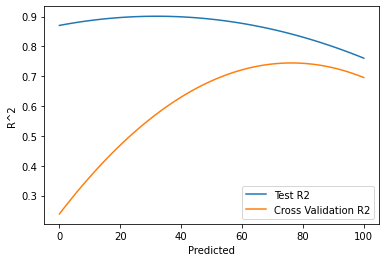

In [8]:
# Plot R^2 as a function of Percent Log Linear
plt.plot(list(range(101)), r2_test_list, label= "Test R2")
plt.plot(list(range(101)), r2_cv_full_mean_list, label= "Cross Validation R2")
plt.xlabel('Predicted')
plt.ylabel('R^2')
plt.legend()
if save:
    plt.savefig("figures/ensemble/r2-vs-pct_log_lin.png", transparent=True, bbox_inches="tight")
plt.show()

In [9]:
# Ensembling

i = 76

# KFold Cross-Validation
r2_cv_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):

    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 

    # Standard Scaler
    features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)

    # Fit OLS
    ols_model = sm.OLS(target_train_cv_array, sm.add_constant(features_train_cv_scaled_array[:,0:5]))
    ols_results = ols_model.fit() # Fit model

    features_train_cv_scaled_df = pd.DataFrame(features_train_cv_scaled_array[:,5:10]).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
    features_train_cv_scaled_df['OnToDoLists'] = 10**target_train_cv_array-1
    features_val_cv_scaled_df = pd.DataFrame(features_val_cv_scaled_array[:,5:10]).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
    features_val_cv_scaled_df['OnToDoLists'] = 10**target_val_cv_array-1

    # Fit Poisson
    poisson_glm_model = smf.glm("OnToDoLists ~ Sqrt_StarRatings + Sqrt_Ticks + Sqrt_Avg_Stars + Sqrt_Length + Sqrt_Grade", data=features_train_cv_scaled_df, family=sm.families.Poisson())
    poisson_glm_results = poisson_glm_model.fit()

    # Ensemble Model
    ensemble_array = 0.01*i*(10**ols_results.predict(sm.add_constant(features_val_cv_scaled_array[:,0:5]))-1) + (1-0.01*i)*poisson_glm_results.predict(features_val_cv_scaled_df)

    # Collect results on the validation set
    SSE = sum((10**target_val_cv_array-1 - ensemble_array)**2)
    SST = sum((10**target_val_cv_array-1 - np.mean(10**target_val_cv_array-1))**2)
    r2_cv_list.append(1-SSE/SST)

print(r2_cv_list)
print('val_r2_score: ', mean(r2_cv_list),' +/- ', stdev(r2_cv_list))

# Test
features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
features_test_scaled_array = scaler.transform(features_test_chosen_df)

# Fit OLS
ols_model = sm.OLS(target_train_ser, sm.add_constant(features_train_scaled_array[:,0:5]))
ols_results = ols_model.fit()

# Fit Poisson
features_train_scaled_df = pd.DataFrame(features_train_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
features_train_scaled_df['OnToDoLists'] = 10**target_train_array-1
features_test_scaled_df = pd.DataFrame(features_test_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
features_test_scaled_df['OnToDoLists'] = 10**target_test_array-1

poisson_glm_model = smf.glm("OnToDoLists ~ Sqrt_StarRatings + Sqrt_Ticks + Sqrt_Avg_Stars + Sqrt_Length + Sqrt_Grade", data=features_train_scaled_df, family=sm.families.Poisson())
poisson_glm_results = poisson_glm_model.fit()

# Ensemble Model
ensemble_array = 0.01*i*(10**ols_results.predict(sm.add_constant(features_test_scaled_array[:,0:5]))-1) + (1-0.01*i)*poisson_glm_results.predict(features_test_scaled_df)

# Collect results on the test set
SSE = sum((10**target_test_array-1 - ensemble_array)**2)
SST = sum((10**target_test_array-1 - np.mean(10**target_test_array-1))**2)

print('test_r2_score: ', 1-SSE/SST) #Get score

[0.8398804640582975, 0.6920451840560087, 0.6380819555661648, 0.748748002895564, 0.8031225349404216]
val_r2_score:  0.7443756283032913  +/-  0.08159091648379568
test_r2_score:  0.8420211467188353


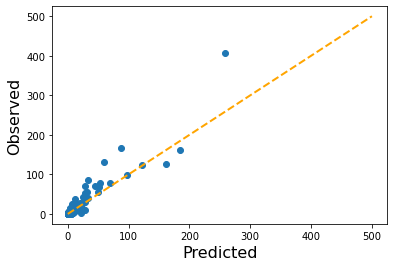

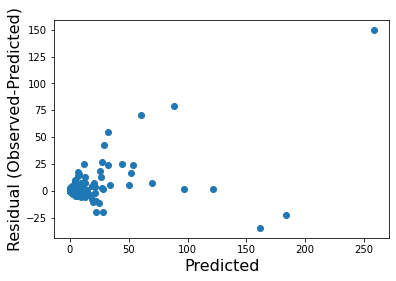

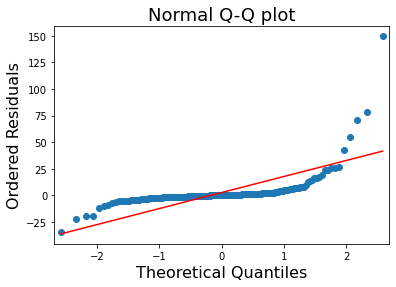

In [10]:
# inputs
x = ensemble_array
y = 10**target_test_array-1


# Predicted vs. Observed
predict_obs_df = pd.DataFrame({'predicted': x, 'observed': y})
fig = plot_single_scatter(predict_obs_df, 'predicted', 'observed',
                          xlabel='Predicted', ylabel='Observed',
                          color=None, figsize=None)
plt.plot([0, 500], [0, 500], c='orange', lw = 2, ls='--', label= "Equal")
if save:
    plt.savefig("figures/ensemble/observed-vs-predicted.png", transparent=True, bbox_inches="tight")


# Predicted vs. Residual
predict_res_df = pd.DataFrame({'predicted': x, 'residual': y-x})
fig = plot_single_scatter(predict_res_df, 'predicted', 'residual',
                          xlabel='Predicted', ylabel='Residual (Observed-Predicted)',
                          color=None, figsize=None)
if save:
    plt.savefig("figures/ensemble/residual-vs-predicted.png", transparent=True, bbox_inches="tight")

    
# QQ Plot
fig = plot_qq(predict_res_df['residual'], "Theoretical Quantiles", "Ordered Residuals", "Normal Q-Q plot")
if save:
    plt.savefig("figures/ensemble/normal-qq-plot.png", transparent=True, bbox_inches="tight")

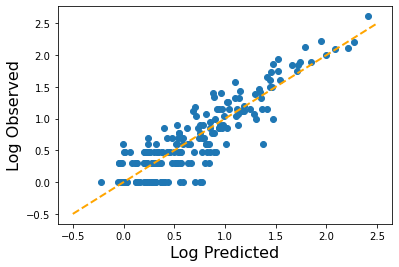

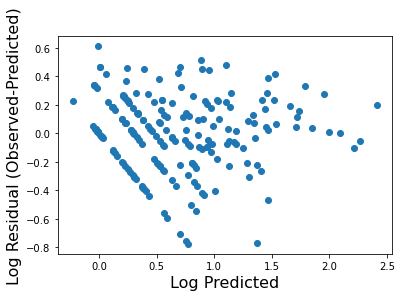

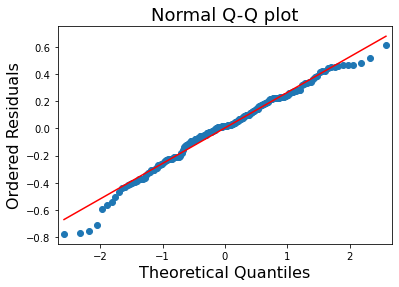

In [11]:
# inputs
x = np.log(ensemble_array+1)/math.log(10)
y = target_test_array


# Predicted vs. Observed
predict_obs_df = pd.DataFrame({'predicted': x, 'observed': y})
fig = plot_single_scatter(predict_obs_df, 'predicted', 'observed',
                          xlabel='Log Predicted', ylabel='Log Observed',
                          color=None, figsize=None)
plt.plot([-0.5, 2.5], [-0.5, 2.5], c='orange', lw = 2, ls='--', label= "Equal")
if save:
    plt.savefig("figures/ensemble/log_observed-vs-log_predicted.png", transparent=True, bbox_inches="tight")


# Predicted vs. Residual
predict_res_df = pd.DataFrame({'predicted': x, 'residual': y-x})
fig = plot_single_scatter(predict_res_df, 'predicted', 'residual',
                          xlabel='Log Predicted', ylabel='Log Residual (Observed-Predicted)',
                          color=None, figsize=None)
if save:
    plt.savefig("figures/ensemble/log_residual-vs-log_predicted.png", transparent=True, bbox_inches="tight")

    
# QQ Plot
fig = plot_qq(predict_res_df['residual'], "Theoretical Quantiles", "Ordered Residuals", "Normal Q-Q plot")
if save:
    plt.savefig("figures/ensemble/log-qq-plot.png", transparent=True, bbox_inches="tight")